## Imports and Config

In [1]:
import gymnasium as gym
import numpy as np
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 0.0005
UPDATE_EVERY = 20

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dueling DQN

- Dueling DQN is a variant of the DQN algorithm that separates the learning of the value and advantage functions. 

- This allows the agent to learn which states are valuable and in which states the actions really matter, without having to learn the effect of each action in each state. 

- This is particularly useful in environments where the effect of the action is independent of the state, or in states where the action has no effect.

### Network

This contains the base Network class. We implement 2 variants of Dueling DQN:
1. `Type 1`: $$Q(s,a; \theta) = V(s;\theta) + (A(s,a;\theta) - \frac{1}{|A|} \sum_{a'} A(s,a';\theta))$$
2. `Type 2`: $$Q(s,a; \theta) = V(s;\theta) + (A(s,a;\theta) - \max_{a'} A(s,a';\theta))$$

In [4]:
class QNetwork(nn.Module):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.common_layers = nn.ModuleList(
            [nn.Linear(state_size, hidden_layer_size)]
            + [
                nn.Linear(hidden_layer_size, hidden_layer_size)
                for _ in range(n_hidden_layers)
            ]
        )
        self.value_layer = nn.Linear(hidden_layer_size, 1)
        self.advantage_layer = nn.Linear(hidden_layer_size, action_size)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [5]:
class QNetwork_1(QNetwork):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork_1, self).__init__(
            state_size, action_size, seed, n_hidden_layers, hidden_layer_size
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""

        x = state
        for layer in self.common_layers:
            x = F.relu(layer(x))
        value = self.value_layer(x)
        advantage = self.advantage_layer(x)
        action_values = value + advantage - advantage.mean()
        return action_values

In [6]:
class QNetwork_2(QNetwork):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork_2, self).__init__(
            state_size, action_size, seed, n_hidden_layers, hidden_layer_size
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""

        x = state
        for layer in self.common_layers:
            x = F.relu(layer(x))
        value = self.value_layer(x)
        advantage = self.advantage_layer(x)
        action_values = value + advantage - advantage.max()
        return action_values

### Replay Buffer

- The Q-Network makes use of a replay buffer of size `BUFFER_SIZE` to store experience tuples. 

- The replay buffer is used to sample a batch of experiences to train the Q-Network.

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Exploration Policy

We provide 2 exploration policies:

1. `epsilonGreedyAction`: This is a simple exploration policy that selects a random action with probability `epsilon`, and the action with the highest Q-value otherwise.

2. `SoftmaxAction`: This is a more sophisticated exploration policy that selects actions according to the softmax of the Q-values.

In [8]:
def epsilonGreedyAction(action_values, epsilon):
    if random.random() > epsilon:
        return np.argmax(action_values)
    else:
        return random.choice(len(action_values))
    
def SoftmaxAction(action_values, tau):
    probs = softmax(action_values / tau)
    return np.random.choice(len(action_values), p=probs)

### Dueling DQN Agent

- `act()` - returns an action given a state

- `learn()` - updates the Q-Network based on the experience tuple.

In [9]:
class DDQN_Agent():

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        type: int = 1,
        action_policy: callable = SoftmaxAction,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
        learning_rate: float = LR,
    ):
        """Agent-Environment Interaction"""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        random.seed(seed)
        self.type = type
        self.action_policy = action_policy
        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate

        """ Q-Network """
        if type == 1:
            self.qnetwork_local = QNetwork_1(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_1(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
        elif type == 2:
            self.qnetwork_local = QNetwork_2(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_2(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
        else:
            raise ValueError("type must be either 1 or 2")

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        """ Replay memory"""
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        """ Initialize time step (for updating every UPDATE_EVERY steps) """
        self.t_step = 0

    def reset(self, seed: int = 0):
        
        self.seed = seed
        random.seed(seed)
        if self.type == 1:
            self.qnetwork_local = QNetwork_1(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_1(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
        elif self.type == 2:
            self.qnetwork_local = QNetwork_2(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_2(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
        else:
            raise ValueError("type must be either 1 or 2")

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, self.seed)
        self.t_step = 0

    def step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        """Save experience in replay memory"""
        self.memory.add(state, action, reward, next_state, done)

        """ If enough samples are available in memory, get random subset and learn """
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ Update the target network every UPDATE_EVERY steps """
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state: np.ndarray, tau: float = 1.0) -> int:

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        """ Action Selection as per policy """
        action = self.action_policy(action_values.cpu().data.numpy().squeeze(), tau)
        return action

    def learn(self, experiences: namedtuple, gamma: float = GAMMA):
        """+E EXPERIENCE REPLAY PRESENT"""
        states, actions, rewards, next_states, dones = experiences

        """ Get max predicted Q values (for next states) from target model """
        Q_targets_next = (
            self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        )

        """ Compute Q targets for current states """
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        """ Get expected Q values from local model """
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        """ Compute loss """
        loss = F.mse_loss(Q_expected, Q_targets)

        """ Minimize the loss """
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

# Trainer

- The Trainer class is used to train an `agent` in a given environment `env`. 

- It has a `train` method, where the agent interacts with the environment and learns from the experiences. The exploration is controlled by the `epsilon` parameter, which initially favours exploration and moves towards exploitation as training progresses.

In [10]:
class Trainer:

    def __init__(self, agent: DDQN_Agent, env: gym.Env, threshold: float = 195.0):
        self.agent = agent
        self.env = env
        self.threshold = threshold
        self.scores_mean = []
        self.scores_std = []

    def train_single_run(
        self,
        seed: int = 0,
        n_episodes: int = 2000,
        max_t: int = 1000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):

        self.agent.seed = random.seed(seed)
        scores_window = deque(maxlen=100)
        scores_list = []
        tau = tau_start

        for i_episode in range(1, n_episodes + 1):
            state, _ = self.env.reset()
            score = 0

            for t in range(max_t):
                action = self.agent.act(state, tau)
                next_state, reward, done, _, _ = self.env.step(action)
                self.agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            scores_list.append(score)

            tau = max(tau_end, tau_decay * tau)

            print(
                f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}",
                end="",
            )

            if i_episode % 100 == 0:
                print(
                    f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}"
                )
            if np.mean(scores_window) >= self.threshold:
                print(
                    f"\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}"
                )
                torch.save(self.agent.qnetwork_local.state_dict(), "checkpoint.pth")
                break

        return scores_list

    def train_multiple_runs(
        self,
        n_runs: int = 5,
        seed_arr: np.ndarray = [0, 1, 2, 3, 4],
        n_episodes: int = 2000,
        max_t: int = 1000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):
        all_scores = []
        for i in range(n_runs):
            print(f"RUN {i+1}")
            self.agent.reset(seed_arr[i])

            print(f"Seed: {self.agent.seed}")
            print(f"Type: {self.agent.type}")
            print(f"Hidden Layers: {self.agent.n_hidden_layers}")
            print(f"Hidden Layer Size: {self.agent.hidden_layer_size}")
            print(f"Learning Rate: {self.agent.learning_rate}")

            begin_time = datetime.datetime.now()
            scores = self.train_single_run(
                seed_arr[i], n_episodes, max_t, tau_start, tau_end, tau_decay, render
            )
            end_time = datetime.datetime.now()
            print(f"Time taken: {end_time - begin_time}")
            print("*" * 50)
            print(np.mean(scores), np.max(scores), np.min(scores))
            all_scores.append(scores)

        max_episode = max([len(scores) for scores in all_scores])

        all_scores = [
            scores + [np.mean(scores[-10:])] * (max_episode - len(scores))
            for scores in all_scores
        ]
        self.scores_mean = np.mean(all_scores, axis=0)
        self.scores_std = np.std(all_scores, axis=0)

    def render_run(self):
        state = self.env.reset()
        for t in range(1000):
            action = self.agent.act(state)
            self.env.render()
            state, reward, done, _ = self.env.step(action)
            if done:
                break

### Setting random seeds

In [11]:
N_RUNS = 5
seed_arr = sorted([int(np.random.randint(0, 1000)) for _ in range(N_RUNS)])
print(seed_arr)


def my_avg(scores, window=3):
    return np.array(
        [np.mean(scores[i : i + window]) for i in range(len(scores) - window)]
    )

[97, 169, 255, 412, 635]


### Example Usage

In [12]:
env = gym.make("CartPole-v1", render_mode="human")
state_size = env.observation_space.shape[0]
n_actions = env.action_space.n
env.reset(seed=0)

# render the environment
env.render()

agent = DDQN_Agent(
    state_size=state_size,
    action_size=n_actions,
    seed=0,
    type=1,
    n_hidden_layers=2,
    hidden_layer_size=128,
    learning_rate=0.005,
)

trainer = Trainer(agent, env, threshold=195.0)
trainer.train_multiple_runs(
    n_runs=N_RUNS, seed_arr=seed_arr, n_episodes=2000, render=True
)

RUN 1
Seed: 97
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 100	Average Score: -213.61
Episode 200	Average Score: -156.71
Episode 300	Average Score: -119.84
Episode 382	Average Score: -99.862
Environment solved in 382 episodes!	Average Score: -99.86
Time taken: 0:03:11.877312
**************************************************
-149.2591623036649 -69.0 -1000.0
RUN 2
Seed: 169
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 100	Average Score: -215.59
Episode 200	Average Score: -131.96
Episode 300	Average Score: -104.05
Episode 338	Average Score: -99.943
Environment solved in 338 episodes!	Average Score: -99.94
Time taken: 0:02:44.024328
**************************************************
-145.00887573964496 -64.0 -1000.0
RUN 3
Seed: 255
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 100	Average Score: -213.53
Episode 200	Average Score: -121.11
Episode 300	Average Score: -110.18
Episode 400	Average Sc

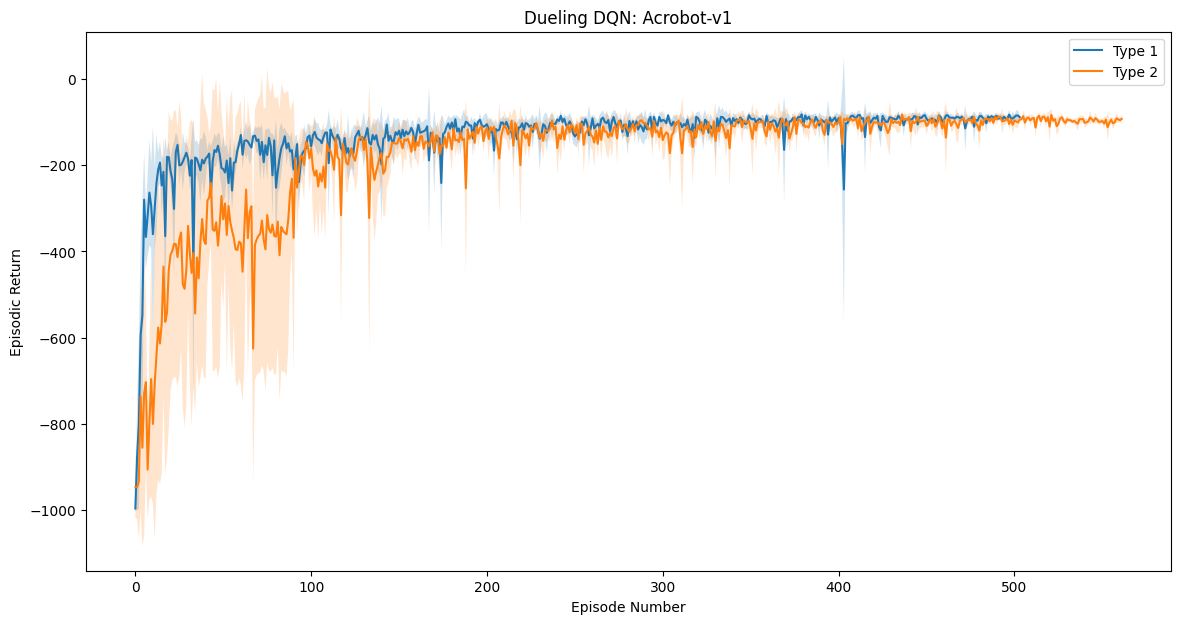

In [16]:
hidden_layer_size = 128
n_hidden_layers = 2
learning_rate = 0.005

plt.figure(figsize=(14, 7))


trainer_list_4 = []
for t in [1, 2]:

    env = gym.make("Acrobot-v1")
    state_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.reset(seed=0)

    agent = DDQN_Agent(
        state_shape,
        n_actions,
        type=t,
        action_policy=SoftmaxAction,
        hidden_layer_size=hidden_layer_size,
        n_hidden_layers=n_hidden_layers,
        learning_rate=learning_rate,
    )
    trainer = Trainer(agent, env, threshold=-100.0)
    trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr)

    plt.plot(trainer.scores_mean, label=f"Type {t}")

    plt.fill_between(
        range(len(trainer.scores_mean)),
        trainer.scores_mean - trainer.scores_std,
        trainer.scores_mean + trainer.scores_std,
        alpha=0.2,
    )
    trainer_list_4.append(trainer)

plt.title("Dueling DQN: Acrobot-v1")
plt.xlabel("Episode Number")
plt.ylabel("Episodic Return")
plt.legend()
plt.show()